# THE EFFECT OF SENTIMENTS IN COMMUNICATION ON A TEAM PERFORMANCE

## by Abay Jumabayev

> Submitted to Central European University <br>
> Department of Economics and Business <br>
> In partial fulfillment of the requirements for the degree of  Masters of Arts in Economics


This notebook provides:
* an information about the project,
* a description of the game and the data,
* an analysis of the data


## Short info about the project

I want to understand the effect of certain sentiments in communication on the performance of a team. Being rude to a team or just to one member can change the mood of the team, which in turn could deteriorate the way the team works. As people are social creatures and spend a significant amount of time performing a job, it is important to understand whether social behavior has an impact on team performance. I reduce a definition of a team to a small group (4 to 6 people) that consists of workers who are (i) high educated, better-paid workers, (ii) who frequently change teams, and (iii) who tend to work remotely. Job positions like a management consultant, software engineer, or researcher fit into the definition of workers in the team.

However, it is difficult to get the data on all the communication between team members and quantify the performance. That is why I focus on the Dota 2, a multiplayer online battle arena (MOBA) video game. In this game people, communicate and accomplish tasks in a team, which is similar to the work environment. Due to the recent pandemic, remote jobs are getting popular, and workers shift to using chats instead of verbal communication. This makes communication in work teams look more similar to the one in Dota 2. Moreover, the performance in the game is measurable and equal to the outcome of a match.

I use the dataset parsed from Opendota, an open-source platform, containing 50,000 matches. Using another dataset of texts labeled by toxicity I build a model that takes a text as an input and outputs whether the text was toxic or not. I define toxicity as a form of anti-social behavior, and a toxic text is a text that is rude and disrespectful to a reader. Using the model, I label every message sent in Dota 2 chats. Then I transform Dota 2 data to calculate teams’ toxicity levels, in-game attributes, and teams’ skill levels in order to use an OLS regression. 

OLS results show that toxicity decreases the performance of a team. Having an extra toxic player in a team reduces the chances of winning a game by 1%. The coefficient is statistically significant at a 1% level. This result brings a new determinant of team success, which, to the best of my knowledge, was not considered before in the literature.


## Description of a game
Dota 2 is played in matches between two teams of five players, with each team occupying and defending their own separate base on the map. Each of the ten players independently controls a powerful character known as a "hero" that all have unique abilities and differing styles of play. During a match players collect experience points (XP) and buy items (with gold) for their heroes to successfully defeat the opposing team's heroes in player versus player combat. A team wins by being the first to destroy the other team's "Ancient", a large structure located within their base. Ancients are located in the left bottom and right upper corners. 

<img src=https://i.imgur.com/iqE4fxr.png width="700">

To destroy the ancient players need XP to level up a hero and gold to buy inventory. For any kill, a hero gains XP and gold. There are three types of characters a player can kill: 
1. creeps, 
2. neutrals, 
3. other heroes. 

Creeps are non-player characters (NPC) that regularly march from each team's Ancient towards the other Ancient. Creeps march only by lanes (top, mid, bottom) and they are considered to be pawns of each team. Usually heroes help friendly creeps to kill the enemy creeps. 

Neutral creeps are NPCs that appear in the jungle. Unlike creeps, they are not playing for any team (hence, the name neutral) and don't move unless get attacked. Heroes can "switch" from lanes to the jungle and kill neutral creeps.

Heroes are human players. There is a total of 10 heroes (10 players), 5 for each team. Sometimes, when several heroes from the opposing teams meet they can decide to fight and get gold and XP. If a hero dies, it appears 

Overall, players are either killing creeps on lanes, killing neutrals in jungle, or killing heroes. This strategy lasts until one of the team gains enough gold and XP to destroy the ancient.

## Analysis of the data available

In [1]:
##################################################################
## THIS CELL IS FOR PLAYING SOUND AT THE END OF CODE COMPLETION ##
##################################################################
## Import up sound alert dependencies
from IPython.display import Audio, display

def allDone():
  display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))
## Insert whatever audio file you want above

In [2]:
import pandas as pd
import numpy as np

In [3]:
# teamfights data for each player 
tf_player = pd.read_csv('../Data/Original/teamfights_players.csv')

# teamfights timings
tf = pd.read_csv('../Data/Original/teamfights.csv')

# player info for each minute
player_time = pd.read_csv('../Data/Original/player_time.csv')

# chat data
chat = pd.read_csv('../Data/Original/chat.csv')

# player ratings
player_ratings = pd.read_csv('../Data/Original/player_ratings.csv')

# player info for the match
player = pd.read_csv('../Data/Original/players.csv')

# match information
match = pd.read_csv('../Data/Original/match.csv')

# account id info  
match_outcomes = pd.read_csv('../Data/Original/match_outcomes.csv')

### Information about matches

Let's depict the histogram for the duration of matches 

In [4]:
match['duration_min'] = match['duration']/60 

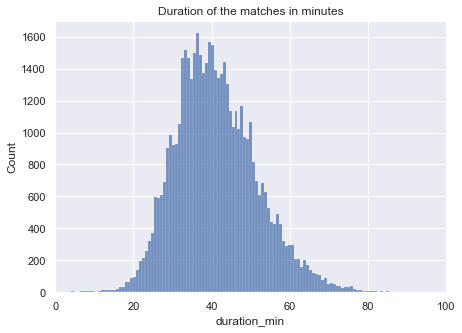

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={"figure.figsize":(7, 5)})
fig, ax = plt.subplots()
sns.histplot(match.duration_min).set_title('Duration of the matches in minutes')
ax.set_xlim(0,100)
#ax.set_xticks(range(0,100))
plt.show()

As we can see, the duration of a match ranges from 30 to 50 minutes 

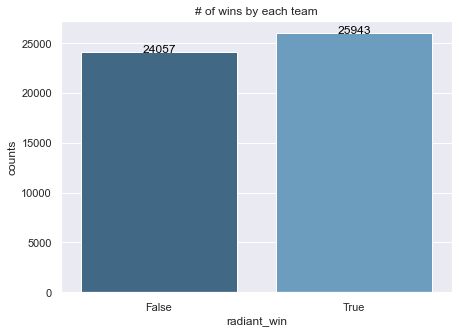

In [6]:
groupedvalues=match.groupby(['radiant_win']).size().reset_index(name='counts')

pal = sns.color_palette("Blues_d", len(groupedvalues))
rank = groupedvalues["counts"].argsort().argsort() 
g=sns.barplot(x='radiant_win',y='counts',data=groupedvalues, palette=np.array(pal[::-1])[rank])
g.set_title('# of wins by each team')
for index, row in groupedvalues.iterrows():
    g.text(row.name, row.counts, round(row.counts,2), color='black', ha="center")

Out of 50,000 matches, the probability of winning is almost 50%

### Information about chat messages

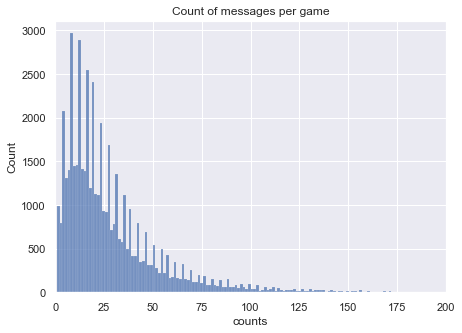

In [7]:
grouped_chat = chat.groupby(['match_id']).size().reset_index(name='counts')

fig, ax = plt.subplots()
sns.histplot(chat.groupby(['match_id']).size().reset_index(name='counts').counts).set_title('Count of messages per game')
ax.set_xlim(0,200)
#ax.set_xticks(range(0,100))
plt.show()

In [8]:
chat.groupby(['match_id']).size().reset_index(name='counts').counts.describe()

count    49772.000000
mean        28.921643
std         27.334633
min          1.000000
25%         12.000000
50%         21.000000
75%         37.000000
max        449.000000
Name: counts, dtype: float64

About 1000 games have no messages. On average, there are 29 messages per game.

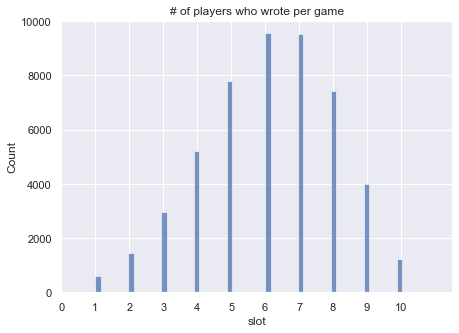

In [9]:
grouped_chat = chat.groupby(['match_id','slot']).size().reset_index(name='counts')
fig, ax = plt.subplots()
sns.histplot(grouped_chat.groupby('match_id').slot.nunique()).set_title('# of players who wrote per game')
ax.set_xticks(range(0,11))
plt.show()

In about 88% of the games, there are 4+ players who text something in game chats.

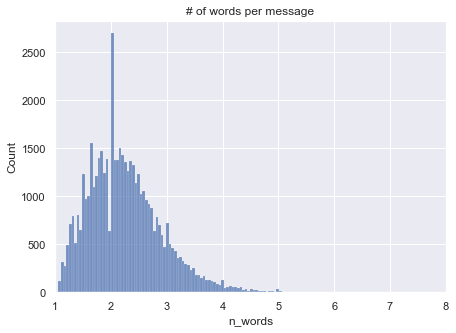

In [10]:
chat['n_words'] = chat['key'].str.split().str.len()
fig, ax = plt.subplots()
sns.histplot(chat.groupby(['match_id']).n_words.mean()).set_title('# of words per message')
ax.set_xlim(1,8)
plt.show()

On average, there are 1.5-2.5 words per message

### Information about chat messages after preprocessing
Let's do the preprocessing and analyze how the situation changes

In [11]:
import os
import re
import nltk
import string

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, LancasterStemmer 

from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC

import warnings
warnings.filterwarnings("ignore")

In [12]:
# load the stopword list provided by the NLTK library
stop_words = stopwords.words('english')

In [13]:
def preprocessing_text(text):
    text = re.sub(r'[^A-Za-z0-9 ]+', ' ', text) #remove all non‐alphanumeric characters except white space
    text = re.sub("(.)\\1{2,}", "\\1", text) #replace 3+ consecutive letters to 1 (loooovvvve -> love)
    text = re.sub(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+)',"", text) # remove emails
    text = re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '' , text) # remove urls
    words = word_tokenize(text.lower())
    tokens = [word for word in words if word not in stop_words]
    tokens = [token for token in tokens if not any(c.isdigit() for c in token)] #remove everything containing digits
    lemmatizer = WordNetLemmatizer()
    tokens_lematized = [lemmatizer.lemmatize(word) for word in tokens]
    tokens_lematized = [word for word in tokens_lematized if word not in stop_words]    
    preprocessed_text = ' '.join(tokens_lematized)
    return preprocessed_text

In [14]:
chat = pd.read_csv('../Data/Modified/chat_preprocessed.csv', index_col=0)

Create chat2, which removes rows with empty messages. E.g. if someone text "200", by preprocessing it will become empty. That's why I get rid of this row

In [15]:
chat2 = chat[chat.text_prepr != ""]
chat2.head()

,match_id,key,slot,time,unit,n_words,text_prepr
0,0,force it,6,-8,6k Slayer,2.0,force
1,0,space created,1,5,Monkey,2.0,space created
2,0,hah,1,6,Monkey,1.0,hah
3,0,ez 500,6,9,6k Slayer,2.0,ez
4,0,mvp ulti,4,934,Kira,2.0,mvp ulti


I got rid of 15% of messages

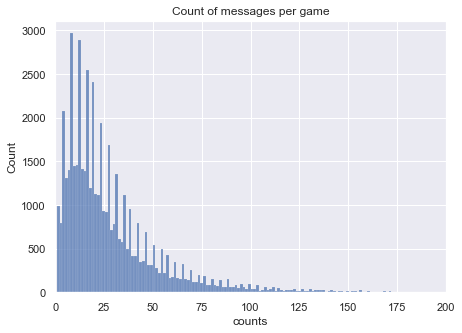

In [16]:
fig, ax = plt.subplots()
sns.histplot(chat2.groupby(['match_id']).text_prepr.size().reset_index(name='counts').counts).set_title('Count of messages per game')
ax.set_xlim(0,200)
#ax.set_xticks(range(0,100))
plt.show()

In [17]:
chat2.groupby(['match_id']).size().reset_index(name='counts').counts.describe()

count    49772.000000
mean        28.921643
std         27.334633
min          1.000000
25%         12.000000
50%         21.000000
75%         37.000000
max        449.000000
Name: counts, dtype: float64

About 1700 games have no messages now. On average, there are 25 messages per game.

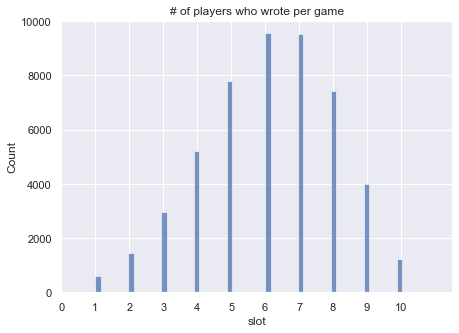

In [18]:
grouped_chat2 = chat2.groupby(['match_id','slot']).size().reset_index(name='counts')
fig, ax = plt.subplots()
sns.histplot(grouped_chat2.groupby('match_id').slot.nunique()).set_title('# of players who wrote per game')
ax.set_xticks(range(0,11))
plt.show()

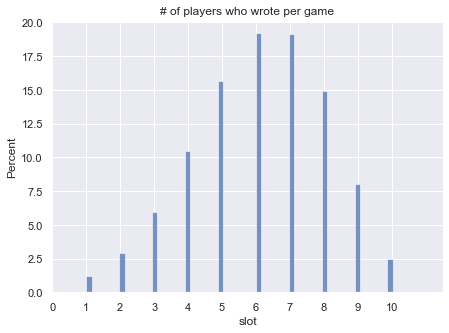

In [19]:
fig, ax = plt.subplots()
sns.histplot(grouped_chat2.groupby('match_id').slot.nunique(),stat= 'percent').set_title('# of players who wrote per game')
ax.set_xticks(range(0,11))
plt.show()

In about 80% of the games, there are 4+ players who text something in game chats.

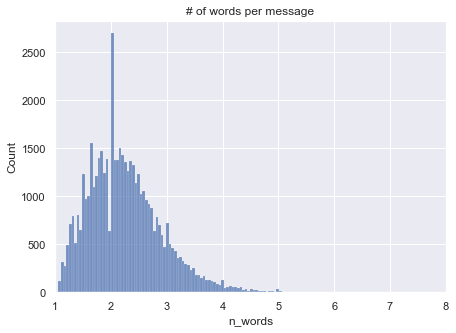

In [20]:
chat2['n_words'] = chat2['key'].str.split().str.len()
fig, ax = plt.subplots()
sns.histplot(chat2.groupby(['match_id']).n_words.mean()).set_title('# of words per message')
ax.set_xlim(1,8)
plt.show()

In [21]:
chat2.groupby(['match_id']).n_words.mean().describe()

count    49772.000000
mean         2.219545
std          0.693235
min          0.916667
25%          1.739130
50%          2.142857
75%          2.607143
max         12.535211
Name: n_words, dtype: float64

### Split data by the first and second half
First, add the total duration of a match to chat df

In [22]:
chat2 = chat2.merge(match[['match_id', 'duration']], on='match_id', how='left')

# create a column dummy which identifies whether the message was sent in the first half
chat2['first_half'] = chat2['time']/chat2['duration']
chat2['first_half'] = np.where(chat2['first_half']< 0.5, 1, 0)

chat2 = chat2.astype({"text_prepr": str})

# combine all messages into one string 
chat2 = chat2.groupby(['match_id', 'first_half', 'slot'])['text_prepr'].apply(' '.join).reset_index()

# Cleaning data
Above was the overview of the whole data.

Let us do the cleaning of the games.

I want to remove some observations based on the following 
* leaver status = 0
* region is not english speaking
* no one wrote anything in the game

## Get rid of games where at least one of the player left the game

In [26]:
leavers_df1 = pd.DataFrame(player[player['leaver_status']==4][['match_id','player_slot']])
#leavers_df1['left'] = 1
leavers_df1['is_leaver_radiant'] = np.where(leavers_df1.player_slot<7, 1, 0)
leavers_df1 = pd.merge(leavers_df1, match[['match_id','radiant_win']],  how='left', left_on=['match_id'], right_on = ['match_id'])

leavers_df1.groupby(['is_leaver_radiant', 'radiant_win']).size()

is_leaver_radiant  radiant_win
0                  False           85
                   True           192
1                  False          184
                   True            74
dtype: int64

In [27]:
# list of match_ids where player left the game
leavers_df = pd.DataFrame(player[player['leaver_status']==4].match_id)
leavers_df['left'] = 1

In [28]:
match = pd.merge(match, leavers_df,  how='left', left_on=['match_id'], right_on = ['match_id'])

In [29]:
match_leavers = match[match['left']==1]
match = match[match['left']!=1]
match.drop(['left'], axis=1, inplace = True)

We get rid of 535 games (about 1%) where players left the game. Let's compare the duration of those games and move to the next cleaning stage 

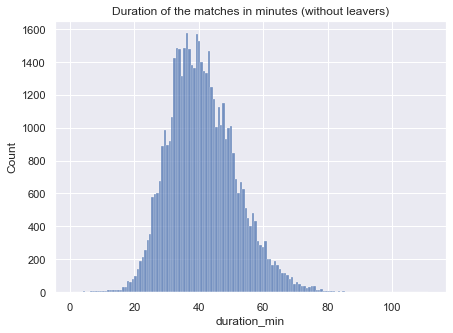

In [30]:
sns.set(rc={"figure.figsize":(7, 5)})
fig, ax = plt.subplots()
sns.histplot(match.duration_min).set_title('Duration of the matches in minutes (without leavers)')
#ax.set_xlim(0,20)
#ax.set_xticks(range(0,100))
plt.show()

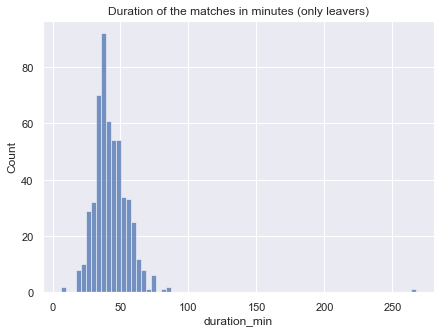

In [31]:
sns.set(rc={"figure.figsize":(7, 5)})
fig, ax = plt.subplots()
sns.histplot(match_leavers.duration_min).set_title('Duration of the matches in minutes (only leavers)')
#ax.set_xlim(0,20)
#ax.set_xticks(range(0,100))
plt.show()

## Get rid of games with no messages

In [32]:
grouped_chat = chat.groupby(['match_id']).size().reset_index(name='counts')
grouped_chat['with_messages'] = 1

match = pd.merge(match, grouped_chat,  how='left', left_on=['match_id'], right_on = ['match_id'])

match = match[match['with_messages']==1]
match.drop(['with_messages'], axis=1, inplace = True)

We got rid of extra 225 games which contained no messages.

## Get rid of games from non English speaking servers

In [35]:
# read cluster data 
cluster = pd.read_csv('../Data/Original/cluster_regions.csv')

# merge with match data
match = pd.merge(match, cluster,  how='left', left_on=['cluster'], right_on = ['cluster'])
match.groupby(['region']).region.count()

In [36]:
chat = pd.merge(chat, match[['match_id','region']],  how='left', left_on=['match_id'], right_on = ['match_id'])

Get rid of empty messages and messages with spaces

In [39]:
def is_blank_mask(df, column):
    return df[column].astype(str).str.fullmatch(r"\s*")

chat['onlyspaces'] = np.where(is_blank_mask(chat, 'text_prepr'),
                            1,
                            0)

chat = chat[chat.onlyspaces==0]
chat.drop(['onlyspaces'], axis=1, inplace = True)

In [42]:
def detection(text):
    try:
        return detect(text)
    except:
        return 'NA'

In [43]:
chat.region.unique()

array(['SINGAPORE', 'EUROPE', 'AUSTRIA', 'STOCKHOLM', 'US EAST',
       'US WEST', nan, 'BRAZIL', 'PW TELECOM GUANGDONG',
       'PW TELECOM SHANGHAI', 'AUSTRALIA', 'PW TELECOM ZHEJIANG', 'JAPAN',
       'CHILE', 'PW UNICOM', 'DUBAI'], dtype=object)

Eye inspection allowed me to identify 'STOCKHOLM', 'BRAZIL', 'PW TELECOM ZHEJIANG', 'PW TELECOM SHANGHAI', 'PW TELECOM GUANGDONG', 'CHILE', 'PW UNICOM', 'DUBAI' to have many non EN words. That is why I get rid of those messages

In [44]:
regions_drop = ['STOCKHOLM', 'BRAZIL', 'PW TELECOM ZHEJIANG', 'PW TELECOM SHANGHAI', 'PW TELECOM GUANGDONG', 'CHILE', 'PW UNICOM', 'DUBAI']

for region in regions_drop:
    chat = chat[chat['region'] != region]

# Predict toxicity

In [45]:
import pickle
# load model
model = pickle.load(open('./toxic_classifier/log_model.pkl', 'rb'))

with open("./toxic_classifier/comment_data.pkl", "rb") as fp:   # Unpickling
    df = pickle.load(fp)

# initialize vectorizer
vectorizer = TfidfVectorizer() 
tfidf = vectorizer.fit_transform(df.comment_text)

# define a function that gets prediction
def get_pred(s):
    x = []
    x.append(s)
   # x[0] = preprocessing_text(x[0])
    vec = vectorizer.transform(x)
    label = model.predict(vec)[0]
    return label

In [52]:
chat = pd.read_csv('../Data/Modified/chat_pred_all_separate.csv', index_col=0)

In [53]:
chat.groupby(['toxic']).region.count()

toxic
0    1054562
1      87967
Name: region, dtype: int64

About 8% of messages are toxic

In [54]:
#chat2.to_csv('../Data/Modified/chat_half_pred.csv')

In [56]:
chat = chat.merge(match[['match_id', 'duration']], on='match_id', how='left')

# create a column dummy which identifies whether the message was sent in the first half
chat['first_half'] = chat['time']/chat['duration']
chat['first_half'] = np.where(chat['first_half']< 0.5, 1, 0)

In [57]:
chat.groupby(['first_half', 'toxic']).toxic.count()

first_half  toxic
0           0        785014
            1         61492
1           0        283946
            1         27712
Name: toxic, dtype: int64

If considering only the first half of the game, 15,890 out of 232,603 players are being toxic, that is about 7% of the time.

In [58]:
chat.groupby(['region']).match_id.count()

region
AUSTRALIA     77307
AUSTRIA       42711
EUROPE       370526
JAPAN          2997
SINGAPORE    242751
US EAST      297690
US WEST      108547
Name: match_id, dtype: int64

## Generating variables of interest

In [60]:
chat = chat[chat.first_half==1]
chat['total_messages'] = chat.groupby(['match_id','slot']).first_half.transform('sum')
# chat['toxic_messages'] = chat.groupby(['match_id','slot', 'toxic']).first_half.transform('sum')
# chat.groupby(['match_id','slot']).key.count()
# df.treats/df.groupby('pet').treats.transform('sum')

# add number of toxic messages to the chat df
df1 = chat.groupby(['match_id','slot', 'toxic']).first_half.count()
df1 = pd.DataFrame(df1)
df1.reset_index(inplace=True)
df1 = df1[df1['toxic']==1]
df1 = df1.rename(columns={"first_half": "tox_messages"})
chat = chat.merge(df1[['match_id', 'slot', 'tox_messages']], on=['match_id','slot'], how='left')
chat['tox_messages'] = chat['tox_messages'].fillna(0)

# calculate toxic rate
chat['toxic_rate'] = chat['tox_messages']/chat['total_messages']

# group by players
chat_grouped = chat.groupby(['match_id', 'slot'])['toxic_rate'].min()
chat_grouped = pd.DataFrame(chat_grouped)
chat_grouped.reset_index(inplace=True)

# pivot
chat_pivot = chat_grouped.pivot(index='match_id', columns='slot', values='toxic_rate')
chat_pivot.reset_index(inplace=True)
chat_rad = chat_pivot[['match_id',0,1,2,3,4]]
chat_dir = chat_pivot[['match_id',5,6,7,8,9]]
chat_rad['no_text'] = chat_rad.isnull().sum(axis=1)
chat_rad = chat_rad.fillna(0)
chat_rad['0toxic'] = np.where(chat_rad[0]> 0, 1, 0)
chat_rad['1toxic'] = np.where(chat_rad[1]> 0, 1, 0)
chat_rad['2toxic'] = np.where(chat_rad[2]> 0, 1, 0)
chat_rad['3toxic'] = np.where(chat_rad[3]> 0, 1, 0)
chat_rad['4toxic'] = np.where(chat_rad[4]> 0, 1, 0)

# calculate n_toxic variable
chat_rad['n_toxic'] = chat_rad['0toxic']+chat_rad['1toxic']+chat_rad['2toxic']+chat_rad['3toxic']+chat_rad['4toxic']

# calculate toxic_rate variable
chat_rad['toxic_rate'] = (chat_rad[0]+chat_rad[1]+chat_rad[2]+chat_rad[3]+chat_rad[4])/5
chat_rad['team'] = 'radiant'

# repeat the process for the second team
chat_dir['no_text'] = chat_dir.isnull().sum(axis=1)
chat_dir = chat_dir.fillna(0)
chat_dir['toxic_rate'] = (chat_dir[5]+chat_dir[6]+chat_dir[7]+chat_dir[8]+chat_dir[9])/5
chat_dir['team'] = 'dire'
chat_dir = chat_dir.rename(columns={5: 0, 6: 1, 7: 2, 8: 3, 9: 4})
chat_dir['0toxic'] = np.where(chat_dir[0]> 0, 1, 0)
chat_dir['1toxic'] = np.where(chat_dir[1]> 0, 1, 0)
chat_dir['2toxic'] = np.where(chat_dir[2]> 0, 1, 0)
chat_dir['3toxic'] = np.where(chat_dir[3]> 0, 1, 0)
chat_dir['4toxic'] = np.where(chat_dir[4]> 0, 1, 0)
chat_dir['n_toxic'] = chat_dir['0toxic']+chat_dir['1toxic']+chat_dir['2toxic']+chat_dir['3toxic']+chat_dir['4toxic']

# combine two teams
frames = [chat_rad, chat_dir]
reg_df = pd.concat(frames)
reg_df['is_radiant'] = np.where(reg_df['team']== 'radiant', 1, 0)
reg_df = pd.merge(reg_df, match[['match_id','radiant_win']] , how='left', left_on=['match_id'], right_on = ['match_id'])
reg_df['win'] = np.where(reg_df['team']== 'radiant', reg_df.radiant_win, abs(reg_df.radiant_win-1))
reg_df.drop([0,1,2,3,4,'0toxic','1toxic','2toxic','3toxic','4toxic'], axis=1, inplace = True)

In [85]:
import statsmodels.formula.api as smf

mod = smf.ols('win ~ toxic_rate + no_text', data=reg_df)
res = mod.fit(cov_type='HC3')
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    win   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     17.61
Date:                Thu, 16 Jun 2022   Prob (F-statistic):           2.25e-08
Time:                        17:43:22   Log-Likelihood:                -52286.
No. Observations:               72064   AIC:                         1.046e+05
Df Residuals:                   72061   BIC:                         1.046e+05
Df Model:                           2                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5374      0.007     81.739      0.0

# Distributions of variables

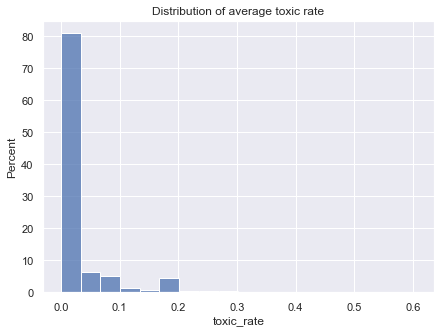

In [86]:
fig, ax = plt.subplots()
sns.histplot(reg_df.toxic_rate, stat = 'percent').set_title('Distribution of average toxic rate')
#ax.set_xlim(0.01,0.7)
plt.show()

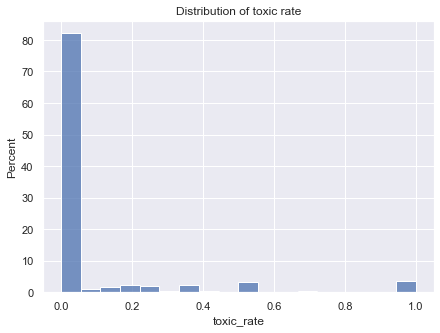

In [87]:
fig, ax = plt.subplots()
sns.histplot(chat_grouped.toxic_rate, stat = 'percent').set_title('Distribution of toxic rate')
#ax.set_xlim(0.01,0.7)
plt.show()

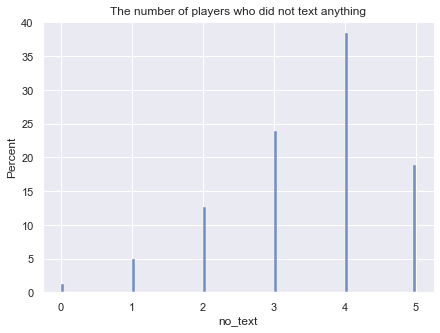

In [88]:
fig, ax = plt.subplots()
sns.histplot(reg_df.no_text, stat = 'percent').set_title('The number of players who did not text anything')
#ax.set_xlim(0.01,0.7)
plt.show()

# Add Control Variables
### Gold, XP (experience), LH (last-hits)
Get those values for the first half of the match. Want to exclude reverse causality issue.

In [89]:
# create a halftime column (in minutes)
match['halftime'] = match['duration']/2
match['halftime'] = (match['halftime']//60)*60

# add player characteristics (gold, xp, lh) from the half time
match = pd.merge(match, player_time , how='left', left_on=['match_id', 'halftime'], right_on = ['match_id','times'])
      
# calculate total gold, xp and lh for each team
match['gold_rad'] =  match.gold_t_0+match.gold_t_1+match.gold_t_2+match.gold_t_3+match.gold_t_4
match['xp_rad'] = match.xp_t_0+match.xp_t_1+match.xp_t_2+match.xp_t_3+match.xp_t_4
match['lh_rad'] = match.lh_t_0+match.lh_t_1+match.lh_t_2+match.lh_t_3+match.lh_t_4

match['gold_dir'] = match.gold_t_128+match.gold_t_129+match.gold_t_130+match.gold_t_131+match.gold_t_132
match['xp_dir'] = match.xp_t_128+match.xp_t_129+match.xp_t_130+match.xp_t_131+match.xp_t_132
match['lh_dir'] = match.lh_t_128+match.lh_t_129+match.lh_t_130+match.lh_t_131+match.lh_t_132

# calculate ratios
match['gold_ratio_rad'] = match['gold_rad']/match['gold_dir']
match['xp_ratio_rad'] = match['xp_rad']/match['xp_dir']
match['lh_ratio_rad'] = match['lh_rad']/match['lh_dir']

match['gold_ratio_dir'] = 1/match['gold_ratio_rad']
match['xp_ratio_dir'] = 1/match['xp_ratio_rad']
match['lh_ratio_dir'] = 1/match['lh_ratio_rad']
      
# make three ratios as separate controls df.
controls_rad = match[['match_id', 'gold_ratio_rad', 'xp_ratio_rad', 'lh_ratio_rad']]
controls_rad['team'] = 'radiant'
controls_rad.columns = ['match_id', 'gold_ratio', 'xp_ratio', 'lh_ratio', 'team']

controls_dir = match[['match_id','gold_ratio_dir', 'xp_ratio_dir', 'lh_ratio_dir']]
controls_dir['team'] = 'dire'
controls_dir.columns = ['match_id', 'gold_ratio', 'xp_ratio', 'lh_ratio', 'team']

frames = [controls_rad, controls_dir]
controls = pd.concat(frames)

### Deaths, kills

In [90]:
# create index of players
lst = range(0,len(tf))
tf['ind'] = lst

lst = np.repeat(lst,10)
tf_player['ind'] = lst

# add a column which shows the team
tf_player['radiant'] = np.where(tf_player['player_slot']<= 5, 1, 0)

# create a halftime column (in minutes)
match['halftime'] = match['duration']/2

# analyze only teamfights from the first half
tf = pd.merge(tf, match[['match_id','halftime']], how='left', left_on=['match_id'], right_on = ['match_id'])
tf['first_half'] = np.where(tf['end']< tf['halftime'], 1, 0)
tf = tf[tf['first_half']==1]

tf_player = pd.merge(tf_player, tf[['ind','first_half']], how='left', left_on=['ind'], right_on = ['ind'])
tf_player = tf_player[tf_player['first_half']==1]

# calculate kill_death_diff
kd = pd.DataFrame(tf_player.groupby(['match_id', 'radiant'])['deaths'].sum()).reset_index()
kd['totals'] = np.repeat( kd.groupby(['match_id'])['deaths'].sum().reset_index().deaths, 2).reset_index().deaths
kd['kills'] = kd['totals'] - kd['deaths']
kd['team'] = np.where(kd['radiant']==1,'radiant', 'dire')
kd['kill_death_diff'] = kd['kills']-kd['deaths']
#kd.drop(['radiant', 'totals', 'deaths', 'kills'], axis=1, inplace = True)

# add it to controls df
controls = pd.merge(controls, kd[['match_id', 'team', 'kill_death_diff']], how='left', left_on=['match_id','team'], right_on = ['match_id','team'])

### Player ratings

In [91]:
player = pd.merge(player[['match_id','account_id', 'player_slot']], player_ratings, how='left', left_on = ['account_id'], right_on = ['account_id'])

# create missing column
player['missing'] = np.where(player['total_wins']>=0, 0,1)

# convert missing to account_id ==0
player = player.fillna(player.mode().iloc[0])
player['account_id'] = np.where(player['missing']==1, 0,player['account_id'])
player['missing'] = np.where(player['account_id']==0, 1,0)

# create pivots for skill_mean, skill_std and abs
skill_mean = player.pivot(index='match_id', columns='player_slot', values='trueskill_mu')
skill_std = player.pivot(index='match_id', columns='player_slot', values='trueskill_sigma')
missing = player.pivot(index='match_id', columns='player_slot', values='missing')

skill_mean.reset_index(inplace=True)
skill_std.reset_index(inplace=True)
missing.reset_index(inplace=True)

# calculate rating variables for each team separately
skill_mean_rad = skill_mean[['match_id',0,1,2,3,4]]
skill_mean_dir = skill_mean[['match_id',128,129,130,131,132]]

skill_std_rad = skill_std[['match_id',0,1,2,3,4]]
skill_std_dir = skill_std[['match_id',128,129,130,131,132]]

missing_rad = missing[['match_id',0,1,2,3,4]]
missing_dir = missing[['match_id',128,129,130,131,132]]

skill_mean_rad['skill_mean'] = (skill_mean_rad[0]+skill_mean_rad[1]+skill_mean_rad[2]+skill_mean_rad[3]+skill_mean_rad[4])/5
skill_mean_rad['team'] = 'radiant'

skill_mean_dir['skill_mean'] = (skill_mean_dir[128]+skill_mean_dir[129]+skill_mean_dir[130]+skill_mean_dir[131]+skill_mean_dir[132])/5
skill_mean_dir['team'] = 'dire'

skill_std_rad['skill_std'] = (skill_std_rad[0]+skill_std_rad[1]+skill_std_rad[2]+skill_std_rad[3]+skill_std_rad[4])/5
skill_std_rad['team'] = 'radiant'

skill_std_dir['skill_std'] = (skill_std_dir[128]+skill_std_dir[129]+skill_std_dir[130]+skill_std_dir[131]+skill_std_dir[132])/5
skill_std_dir['team'] = 'dire'

missing_rad['no_rank'] = (missing_rad[0]+missing_rad[1]+missing_rad[2]+missing_rad[3]+missing_rad[4])
missing_rad['team'] = 'radiant'

missing_dir['no_rank'] = (missing_dir[128]+missing_dir[129]+missing_dir[130]+missing_dir[131]+missing_dir[132])
missing_dir['team'] = 'dire'

frames = [skill_mean_rad[['match_id', 'skill_mean', 'team']], skill_mean_dir[['match_id', 'skill_mean', 'team']]]
skill_mean = pd.concat(frames)

frames = [skill_std_rad[['match_id', 'skill_std', 'team']], skill_std_dir[['match_id', 'skill_std', 'team']]]
skill_std = pd.concat(frames)

frames = [missing_rad[['match_id', 'no_rank', 'team']], missing_dir[['match_id', 'no_rank', 'team']]]
missing = pd.concat(frames)

# add them to controls df
controls = pd.merge(controls, skill_mean, how='left', left_on=['match_id','team'], right_on = ['match_id','team'])
controls = pd.merge(controls, skill_std, how='left', left_on=['match_id','team'], right_on = ['match_id','team'])
controls = pd.merge(controls, missing, how='left', left_on=['match_id','team'], right_on = ['match_id','team'])

## Merge everything into one df

In [92]:
reg_df = pd.merge(reg_df, controls, how='left', left_on=['match_id','team'], right_on = ['match_id','team'])

In [93]:
# delete two matches with NAs
reg_df= reg_df[reg_df['match_id']!=13914]
reg_df= reg_df[reg_df['match_id']!=31438]

In [94]:
# replace NAN with 0. Those are the games that had no teamfights in the first half of the game.
reg_df['kill_death_diff'] = reg_df['kill_death_diff'].fillna(0)

In [95]:
mod = smf.ols('win ~ toxic_rate + no_text', data=reg_df)
res = mod.fit(cov_type='HC3')
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    win   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     17.63
Date:                Thu, 16 Jun 2022   Prob (F-statistic):           2.21e-08
Time:                        17:43:41   Log-Likelihood:                -52283.
No. Observations:               72060   AIC:                         1.046e+05
Df Residuals:                   72057   BIC:                         1.046e+05
Df Model:                           2                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5374      0.007     81.742      0.0

## Regression Tables

In [96]:
import pandas as pd
from sklearn import datasets
import statsmodels.api as sm
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML

est = sm.OLS(endog=reg_df['win'], exog=sm.add_constant(reg_df[['toxic_rate', 'no_text']])).fit(cov_type='HC3')
est2 = sm.OLS(endog=reg_df['win'], exog=sm.add_constant(reg_df[['toxic_rate', 'no_text', 'gold_ratio', 'lh_ratio', 'kill_death_diff']])).fit()
est3 = sm.OLS(endog=reg_df['win'], exog=sm.add_constant(reg_df[['toxic_rate', 'no_text', 'gold_ratio', 'lh_ratio', 'kill_death_diff', 'skill_mean', 'skill_std', 'no_rank']])).fit()

stargazer = Stargazer([est, est2, est3])

In [97]:
stargazer.covariate_order(['toxic_rate', 'no_text', 'gold_ratio', 'lh_ratio', 'kill_death_diff', 'skill_mean', 'skill_std', 'no_rank'])
stargazer.rename_covariates({'toxic_rate': 'toxic rate', 'no_text': '\# no text', 'gold_ratio': 'gold ratio', 'lh_ratio': 'last-hits ratio', 'kill_death_diff': 'kill-death diff',
                            'skill_mean': 'skill mean','skill_std': 'skill st.d.', 'no_rank': '\# no rank'})
stargazer.show_degrees_of_freedom(False)
stargazer

In [98]:
# n_toxic with reg_df

est = sm.OLS(endog=reg_df['win'], exog=sm.add_constant(reg_df[['n_toxic', 'no_text']])).fit(cov_type='HC3')
est2 = sm.OLS(endog=reg_df['win'], exog=sm.add_constant(reg_df[['n_toxic', 'no_text', 'gold_ratio', 'lh_ratio', 'kill_death_diff']])).fit()
est3 = sm.OLS(endog=reg_df['win'], exog=sm.add_constant(reg_df[['n_toxic', 'no_text', 'gold_ratio', 'lh_ratio', 'kill_death_diff', 'skill_mean', 'skill_std', 'no_rank']])).fit()

stargazer = Stargazer([est, est2, est3])
stargazer.covariate_order(['n_toxic', 'no_text', 'gold_ratio', 'lh_ratio', 'kill_death_diff', 'skill_mean', 'skill_std', 'no_rank'])
stargazer.rename_covariates({'n_toxic': '\# toxic', 'no_text': '\# no text', 'gold_ratio': 'gold ratio', 'lh_ratio': 'last-hits ratio', 'kill_death_diff': 'kill-death diff',
                            'skill_mean': 'skill mean','skill_std': 'skill st.d.', 'no_rank': '\# no rank'})
stargazer.show_degrees_of_freedom(False)
stargazer

In [99]:
allDone()